In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import print_function
from IPython.display import display, Math, Latex
from IPython.core.display import HTML

import numpy as np
import pylab as plt
import time
import random
import cv2
from cv2 import cvtColor as convertColor, COLOR_BGR2GRAY, COLOR_GRAY2RGB, \
                resize, imread, imwrite
try:
    from cv2.cv import CV_INTER_NN, \
                       CV_INTER_AREA, \
                       CV_CAP_PROP_FRAME_WIDTH, \
                       CV_CAP_PROP_FRAME_HEIGHT, \
                       CV_CAP_PROP_FPS, \
                       CV_LOAD_IMAGE_GRAYSCALE
except:
    from cv2 import INTER_NEAREST as CV_INTER_NN, \
                    INTER_AREA as CV_INTER_AREA, \
                    CAP_PROP_FRAME_WIDTH as CV_CAP_PROP_FRAME_WIDTH, \
                    CAP_PROP_FRAME_HEIGHT as CV_CAP_PROP_FRAME_HEIGHT, \
                    CAP_PROP_FPS as CV_CAP_PROP_FPS, \
                    IMREAD_GRAYSCALE as CV_LOAD_IMAGE_GRAYSCALE

from scipy.optimize import curve_fit
from scipy import interpolate

import matplotlib.patches as patches
from vision.spike_tools.vis import my_imshow

import os

DEG_TO_RAD = np.pi/180.
SQRT3 = np.sqrt(3.)
INV_SQRT3 = 1./SQRT3
SQRT3_D2 = SQRT3/2.
SQRT2 = np.sqrt(2)
SQRT7 = np.sqrt(7)


d2r = np.pi/180.

def init_img(img_w, img_h, barw, deg, first=True):
    vertical_bars = np.zeros((img_h, img_w), dtype=np.uint8)
    dst = np.zeros_like(vertical_bars)
    r = img_w - 1
    if first:
        vertical_bars[:img_h//2, 0:barw]    = 255
        vertical_bars[img_h//2:, r-barw: r] = 255
    else:
        vertical_bars[:img_h//2, r-barw: r] = 255
        vertical_bars[img_h//2:, 0:barw]    = 255

    dst = vertical_bars.copy()
    image_center = tuple(np.array(dst.shape)/2)
    rot = cv2.getRotationMatrix2D(image_center, deg, 1.)
    dst[:] = cv2.warpAffine(dst, rot, (img_w,img_h))

    return vertical_bars, dst
    

def movement(num_frames, vertical_bars, deg, dx, first=True):
    img_h, img_w = vertical_bars.shape
    dst = np.zeros_like(vertical_bars)
    mult1 = 1 if first is True else -1
    mult2 = -mult1
    images = []
    tx = dx
    for f in range(num_frames):

        trans = np.float32([[1,0, mult1*tx],[0,1,0]])
        dst[:img_h//2, :] = cv2.warpAffine(vertical_bars[:img_h//2, :], 
                                           trans, (img_w,img_h//2))
        trans = np.float32([[1,0, mult2*tx],[0,1,0]])
        dst[img_h//2:, :] = cv2.warpAffine(vertical_bars[img_h//2:, :], 
                                           trans, (img_w,img_h//2))

        image_center = tuple(np.array(dst.shape)/2)
        rot = cv2.getRotationMatrix2D(image_center, deg, 1.)
        dst[:] = cv2.warpAffine(dst, rot, (img_w,img_h))

        tx += dx
        images.append(dst.copy())
    
    return images


def animate_bars(img_w, img_h, barw, deg, num_frames, dx):
    first = True
    vertical_bars, dst = init_img(img_w, img_h, barw, deg, first=first)

    images = [dst.copy()]

    images += movement(num_frames, vertical_bars, deg, dx, first=first)
    
    first = False
    vertical_bars, dst = init_img(img_w, img_h, barw, deg, first=first)
    
    images.append(dst)
    
    images += movement(num_frames, vertical_bars, deg, dx, first=first)
    
    return images

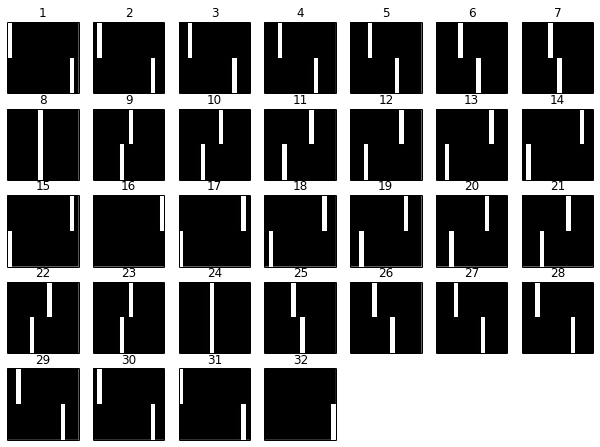

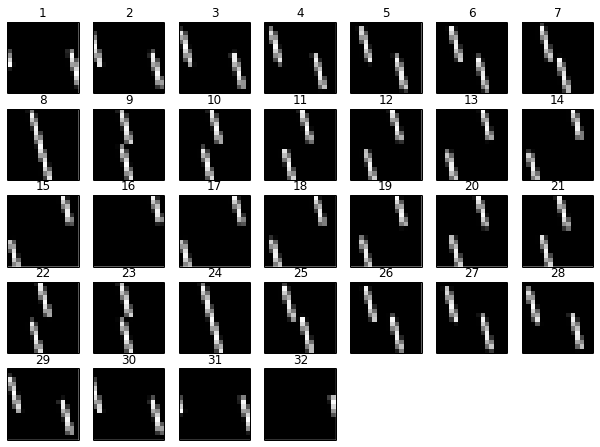

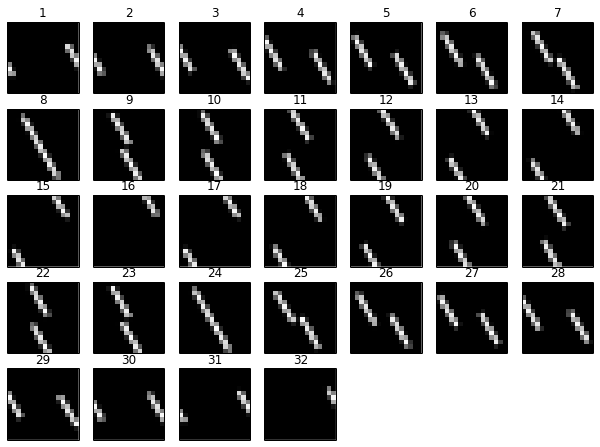

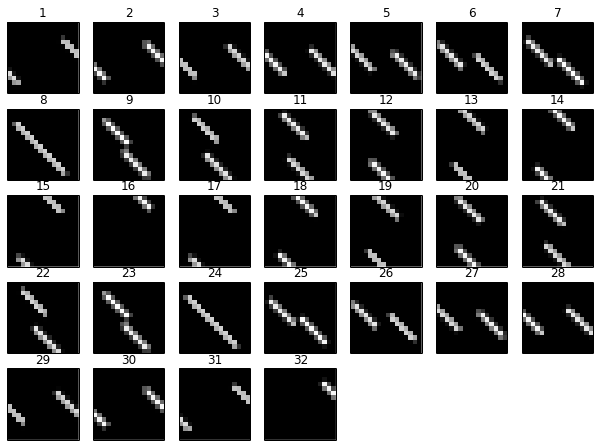

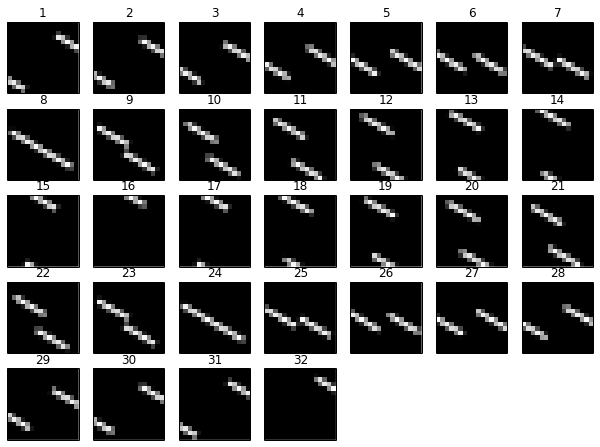

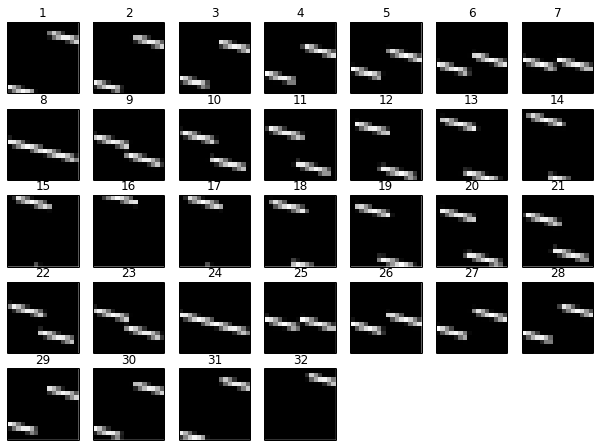

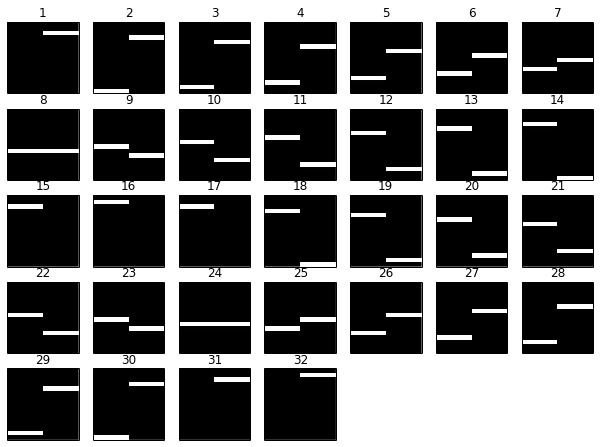

In [6]:
img_w = 16
img_h = 16
dx = 1.
num_frames = int(img_w/dx) - 1
d_deg = 15
num_angs = 7
barw = 1


for deg in range(num_angs):
    deg *= d_deg
    
    out_dir = "./dual_moving_bar_%s_deg"%(deg)
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)

    out_dir = "%s/dx_%f"%(out_dir, dx)
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)

    fname = "bar_frame_%05d_dx_%f.png"

    images = animate_bars(img_w, img_h, barw, deg, num_frames, dx)
    
    HTML("<h1>Angle %d</h1>")
    
    ncols = 7
    nrows = len(images)//ncols + 1
    figs = 1.5
    fig = plt.figure(figsize=(figs*ncols, figs*nrows))
    
    idx = 1
    image_idx = 0
    for img in images:
        ax = plt.subplot(nrows, ncols, idx)
        idx += 1 
        image_idx += 1

        imwrite(os.path.join(out_dir, fname%(image_idx, dx)), img)
        my_imshow(ax, img.copy(), vmin=0, vmax=255)

        ax.set_title(idx-1)
    plt.show()